# DNN: analysis with Keras of 2D data

In [1]:
import numpy as np

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

rng = np.random.default_rng(1758)

plt.rcParams['font.size'] = 13



%run useful.py

2025-03-02 10:25:31.465234: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-02 10:25:31.472742: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 10:25:31.558408: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-02 10:25:31.644604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740907531.702870    5286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740907531.73

## Read data

(2000, 8)
data: 2000
train: 1600


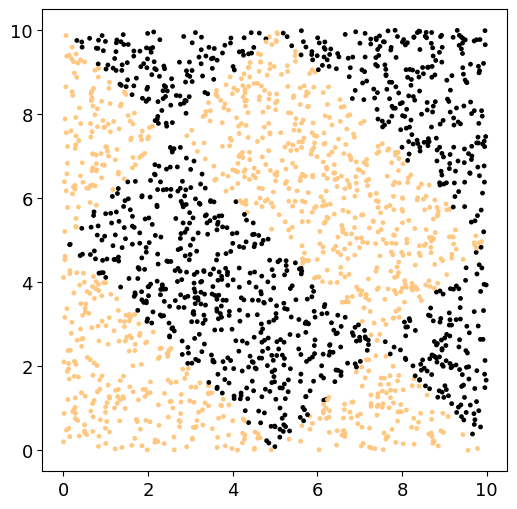

In [2]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
perc_train = 0.8
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)

N_train = int(perc_train * N)
print(f'data: {N}\ntrain: {N_train}')

plot_data(x,y)

## Standardize data

In [3]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split training and test data

In [4]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_test, y_test) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"\t Test:",len(x_test))

Train: 1600 	 Test: 400


## Define the model with Keras / Tensorflow

In [5]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 not so hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

build_model(keras_tuner.HyperParameters())
tuner = keras_tuner.RandomSearch(hypermodel=build_model, objective="val_accuracy", max_trials=15, executions_per_trial=2, overwrite=True, project_name='search')
tuner.search(x_train[200:], y_train[200:], epochs=400, validation_data=(x_train[:200], y_train[:200]))

Trial 15 Complete [00h 01m 39s]
val_accuracy: 0.9675000011920929

Best val_accuracy So Far: 0.9725000262260437
Total elapsed time: 00h 23m 06s


In [7]:
models = tuner.get_best_models(num_models=4)
tuner.results_summary(num_trials=15)


/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/margherita/src/ambiente/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in ./search
Showing 15 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.2
Dropout_2: 0.2
Dropout_3: 0.0
lr: 0.001
optimizer: adam
Score: 0.9725000262260437

Trial 06 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.1
Dropout_2: 0.0
Dropout_3: 0.1
lr: 0.1
optimizer: adam
Score: 0.9700000286102295

Trial 11 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.2
Dropout_2: 0.2
Dropout_3: 0.2
lr: 1e-06
optimizer: RMSprop
Score: 0.9675000011920929

Trial 14 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.2
Dropout_2: 0.1
Dropout_3: 0.1
lr: 0.1
optimizer: sgd_nesterov
Score: 0.9675000011920929

Trial 05 summary
Hyperparameters:
hidd_activation: relu
Dropout_1: 0.0
Dropout_2: 0.1
Dropout_3: 0.2
lr: 0.01
optimizer: RMSprop
Score: 0.9249999821186066

Trial 08 summary
Hyperparameters:
hidd_activation: elu
Dropout_1: 0.2
Dropout_2: 0.0
Dropout_3: 0.2
lr: 1e-06
optim

## Cross Validation

In [8]:
def k_fold_cross_validation(x_train, y_train, k, models):
    # Initialize holders
    best = -1
    best_perf = -1
    results = []
    best_num = -1
    # Divide training set in K folds
    idx = rng.permutation(np.arange(x_train.shape[0]))
    x_folds, y_folds = np.array_split(x_train[idx, :], k), np.array_split(y_train[idx], k)
    
    for i in range(len(models)):
        model_perf = 0
        for test in range(k):
            x_train_fold = np.concatenate([x for i, x in enumerate(x_folds) if i != test])
            y_train_fold = np.concatenate([x for i, x in enumerate(y_folds) if i != test])
            x_validate_fold, y_validate_fold = x_folds[test], y_folds[test]
            k_model = models[i].fit(x_train_fold, y_train_fold, verbose=0)
            model_perf += models[i].evaluate(x_validate_fold, y_validate_fold, verbose=0)[1]
        model_perf /= k
        results.append(model_perf)
        if (best_perf < model_perf):
            best, best_num = models[i], i
            best_perf = model_perf
    return best, best_num, results


best_model, which_best, results = k_fold_cross_validation(x_train, y_train, 5, models)
print(which_best)
print(results)

1
[0.9712499976158142, 0.9793750047683716, 0.9712499976158142, 0.9512500047683716]


## Training

In [9]:
fit = best_model.fit(x_train, y_train,
               epochs = 400, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)

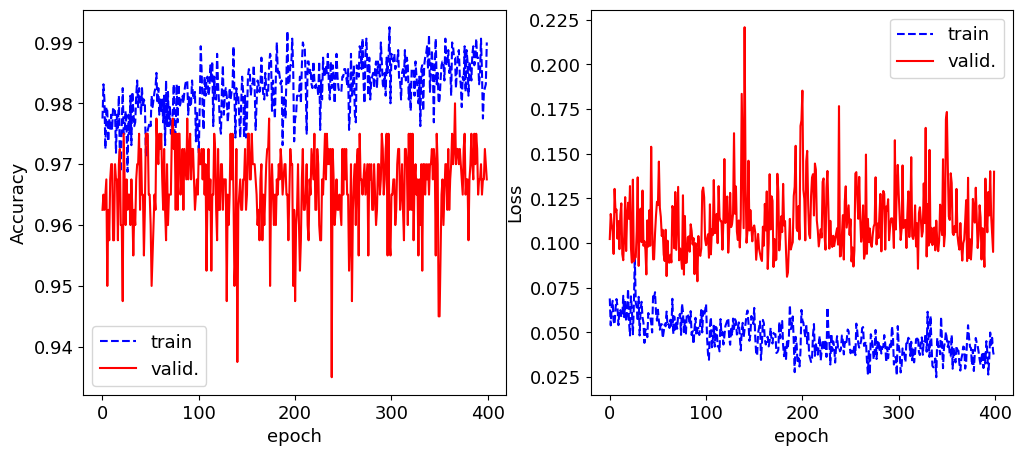

In [10]:
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]
ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Accuracy")
ax.legend()
ax=AX[1]
ax.plot(fit.history['loss'],label="train",c="b",ls="--")
ax.plot(fit.history['val_loss'],label="valid.",c="r")
ax.set_xlabel('epoch')
ax.set_ylabel("Loss")
ax.legend()

## Grid to show preditions

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


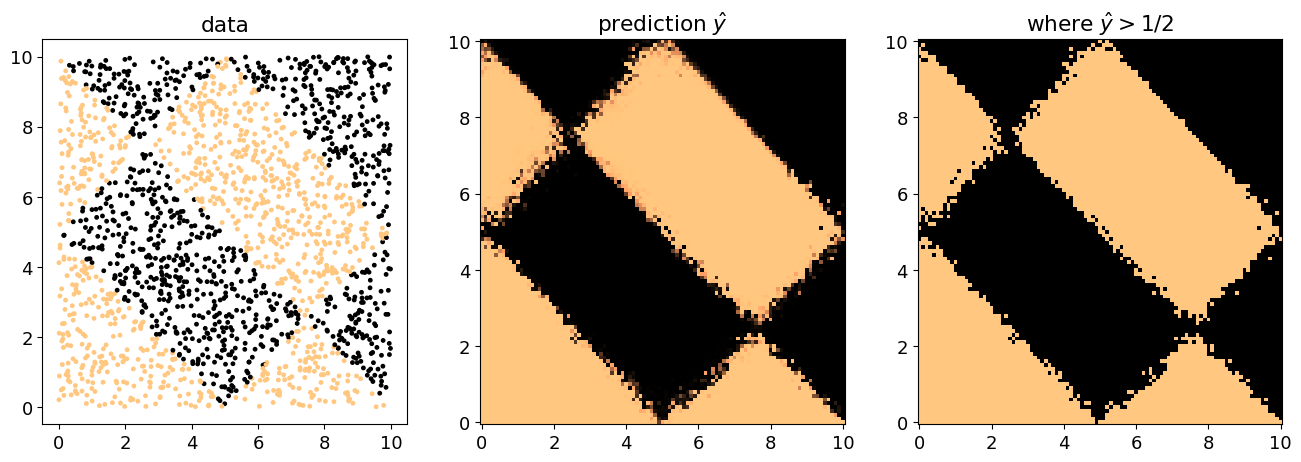

remember: these ar 2 out of L=8 dimensions, of which L-2 contain random noise


In [11]:
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r)

fig,AX=plt.subplots(1,3,figsize=(16,5.))
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()
print(f"remember: these ar 2 out of L={L} dimensions, of which L-2 contain random noise")

## PART 2

4000
(4000, 8)


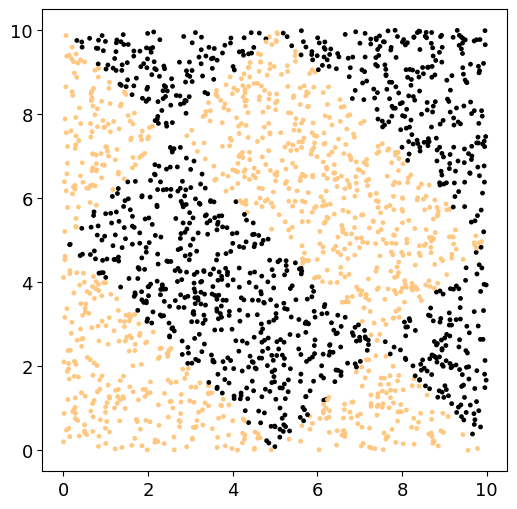

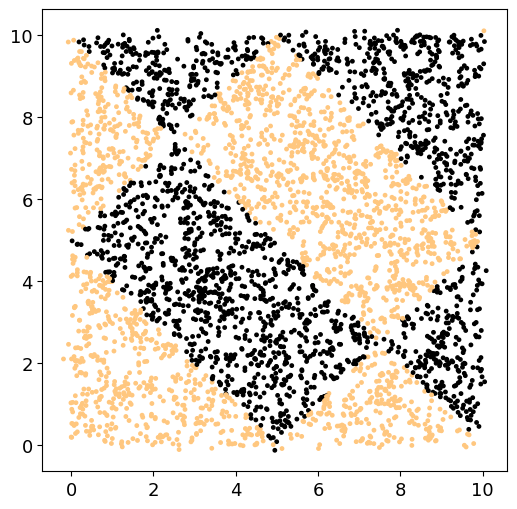

In [15]:
import random

TYPE=3
L=8
N_aug=9000
B=10

# ORIGINAL
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
#print(x.shape)
#print(y.shape)

# REDUCTED
index= random.sample(range(len(x)),int(0.5*x.shape[0]))
x_reducted = x[index]
y_reducted = y[index]
#plot_data(x_reducted,y_reducted)
x_reducted=np.array(x_reducted)
y_reducted=np.array(y_reducted)
#print(x_reducted.shape)
#print(y_reducted.shape)

# INCREASED
np.random.seed(1)
x_increased=np.random.random((N_aug,L))*B #number between (0,1) * width of data sample
y_increased=list(np.zeros(N_aug))
for i in range(N_aug):
    y_increased[i]=NF(x_increased[i],B,TYPE)
#plot_data(x_new,y_new)
y_increased=np.array(y_increased)
#print(x_increased.shape)
#print(y_increased.shape)

# AUGMENTED
x_augmented=np.loadtxt(filename("data",L,TYPE), delimiter=' ')
#distanza media sulla prima feature:
'''
x_sorted=sorted(x_augmented[:,0])
dist=[]
for i in range(1,N):
    dist.append(x_sorted[i]-x_sorted[i-1])
std=np.mean(dist)
'''
for i in range(0,N):
    lista=[]
    for j in range(L):
        lista.append(np.random.normal(loc=x[i,j],scale=0.1))
    x_augmented=np.append(x_augmented,[lista],axis=0)

y_augmented=list(np.zeros(x_augmented.shape[0]))
for i in range(x_augmented.shape[0]):
    y_augmented[i]=NF(x_augmented[i],B,TYPE)

print(len(y_augmented))
print(x_augmented.shape)
x_augmented=np.array(x_augmented)
y_augmented=np.array(y_augmented)
plot_data(x,y)
plot_data(x_augmented,y_augmented)




In [16]:
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss

def prepare_data(x,y):
    """
    Does rescaling and divides into training and test set.
    """
    perc_train=0.8
    N=len(x)
    N_train = int(perc_train * N)
    x_mean = np.mean(x,axis=0)
    x_std  = np.std(x,axis=0)
    #print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
    x = Standardize(x,x_mean,x_std)
    #print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))
    ## Split training and test data
    (x_train, y_train) = (x[0:N_train],y[0:N_train])
    (x_test, y_test) = (x[N_train:],y[N_train:])
    #print("Train:",len(x_train),"\t Validation:",len(x_valid))
    return x_train,y_train,x_test,y_test

In [ ]:
def train_data(X,Y):
    '''
    STO DANDO PER SCONTATO CHE SIA STATO TROVATO E RUNNATO IL BEST MODEL
    '''
    nepoch = 400 #CHANGE HERE FOR FASTER/SLOWER RUN 
    x_train,y_train,x_test,y_test=prepare_data(X,Y)
    fit = best_model.fit(x_train, y_train,
               epochs = nepoch, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)
    
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_accuracy'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],label="train",c="b",ls="--")
    ax.plot(fit.history['val_loss'],label="valid.",c="r")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.legend()


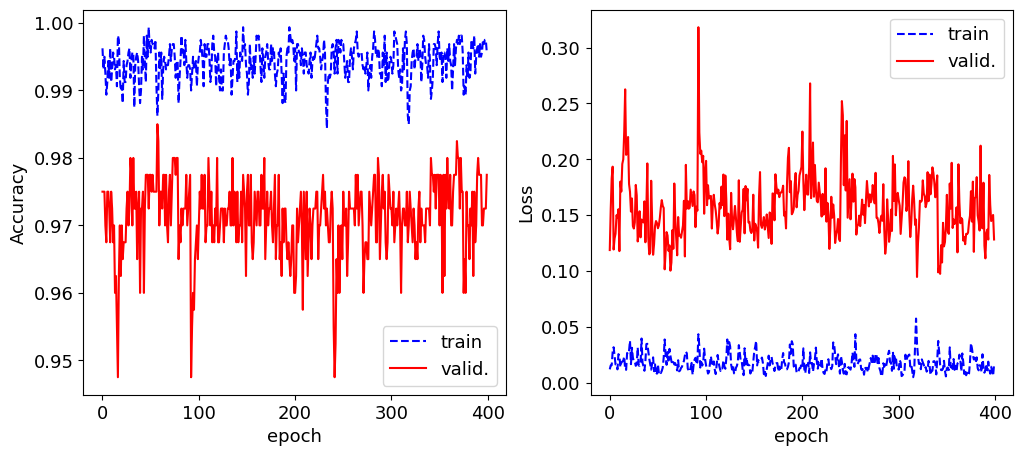

In [ ]:
train_data(x,y)


nel random search i primi tot del training set sono il validation data. Uso il test set solo nel fit del best model perchè il fit non si traina su quello ma nell'evaluate lo prende  e sputa fuori l'accuracy del train set e quella è la validation accuracy sul test set. 


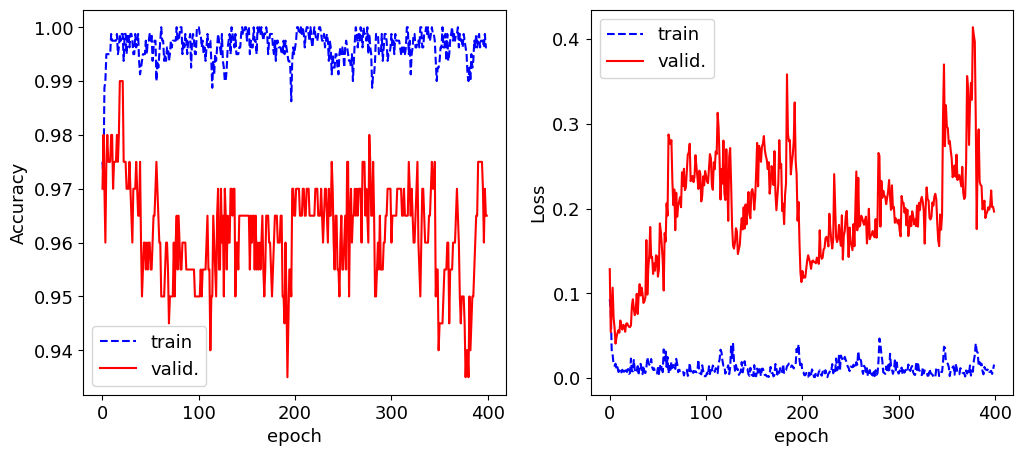

In [25]:
train_data(x_reducted,y_reducted)


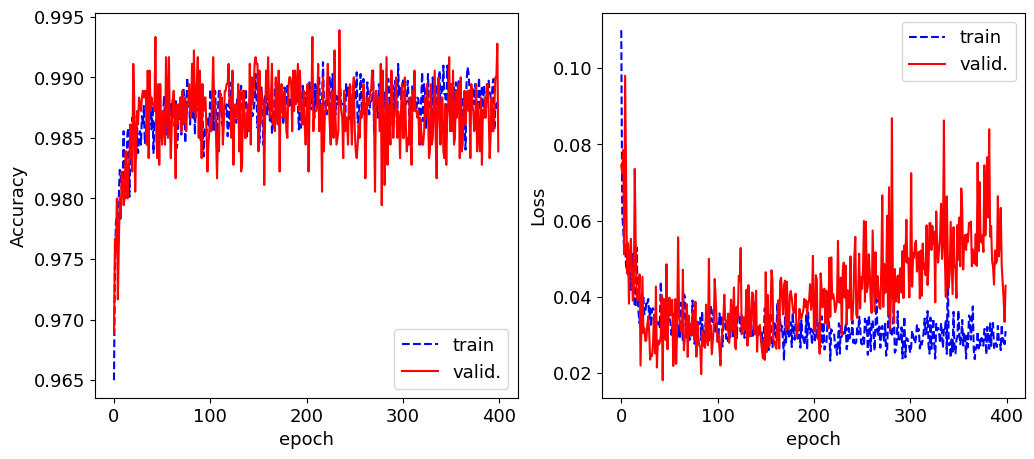

In [26]:
train_data(x_increased,y_increased)  


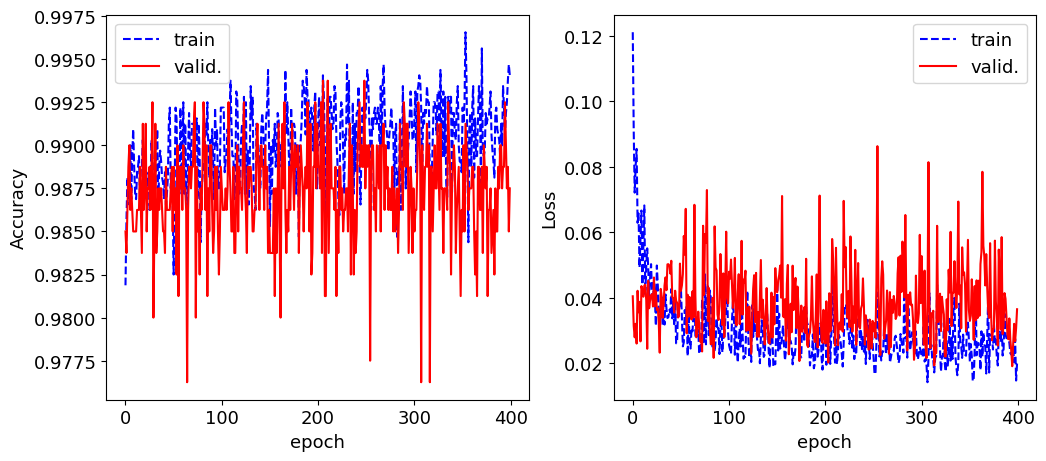

In [27]:
train_data(x_augmented,y_augmented)
